# Ornstein-Uhlenbeck Process
 The Ornstein-Uhlenbeck process is a stochastic process that describes the evolution of a variable over time, where the variable tends to revert to  long-term mean.
 It is often used in finance to model interest rates, stock prices, and other financial variables.
 The process is defined by the following stochastic differential equation (SDE):

 \[
 dX_t = θ(μ - X_t)dt + σdW_t
 \]

 where:
 - \(X_t\) is the value of the process at time \(t\)
 - \(θ\) is the rate of mean reversion
 - \(μ\) is the long-term mean
 - \(σ\) is the volatility of the process
 - \(W_t\) is a standard Wiener process (Brownian motion)
     

In [ ]:
import sys
import os

# Add the parent directory to the sys.path
LaRRR_path = os.path.abspath(os.path.join(os.getcwd(), '..','..'))
sys.path.append(LaRRR_path)

from LaRRR.src.dual.reduced_rank import fit as dual_LaRRR
from LaRRR.src.dual.reduced_rank import fit_to as dual_ToRRR
from LaRRR.src.nn.modules import OrthogonalRandomFeatures
from LaRRR.src.primal.reduced_rank import fit as primal_LaRRR
from LaRRR.src.primal.reduced_rank import fit_to as primal_ToRRR
from LaRRR.src.base import predict, modes, kmd_filter, predict_quantiles,find_best_quantile, smooth_cdf

from LaRRR.src.utils import report


import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensuring reproducibility
np.random.seed(14)

In [2]:
def simulate_ou_process(T=10.0, dt=0.01, X0=None, drift_matrix=None, sigma=None, dim=2):
    """
    Simulate a multidimensional Ornstein-Uhlenbeck process with a non-symmetric drift matrix.
    
    Parameters:
    -----------
    T : float
        Total simulation time
    dt : float
        Time step for simulation
    X0 : numpy.ndarray
        Initial state vector (dim x 1)
    drift_matrix : numpy.ndarray
        Drift matrix (dim x dim), non-symmetric
    sigma : numpy.ndarray
        Diffusion matrix (dim x dim)
    dim : int
        Dimension of the process
        
    Returns:
    --------
    X : numpy.ndarray
        Simulated paths (N x dim)
    t : numpy.ndarray
        Time points
    """
    # Number of time steps
    N = int(T / dt)
    
    # Time points
    t = np.linspace(0, T, N)
    
    # Initialize state vector if not provided
    if X0 is None:
        X0 = np.zeros(dim)
    
    # Initialize drift matrix if not provided
    if drift_matrix is None:
        # Create a non-symmetric drift matrix
        drift_matrix = - np.eye(dim)
    
    # Initialize diffusion matrix if not provided
    if sigma is None:
        sigma = 0.1 * np.eye(dim)
    
    # Pre-allocate array for the process
    X = np.zeros((N, dim))
    X[0] = X0
    
    # Generate the OU process
    for i in range(1, N):
        # Generate multivariate normal random increment
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        
        # Update using Euler-Maruyama discretization
        X[i] = X[i-1] + np.dot(drift_matrix, X[i-1]) * dt + np.dot(sigma, dW)
    
    return X, t

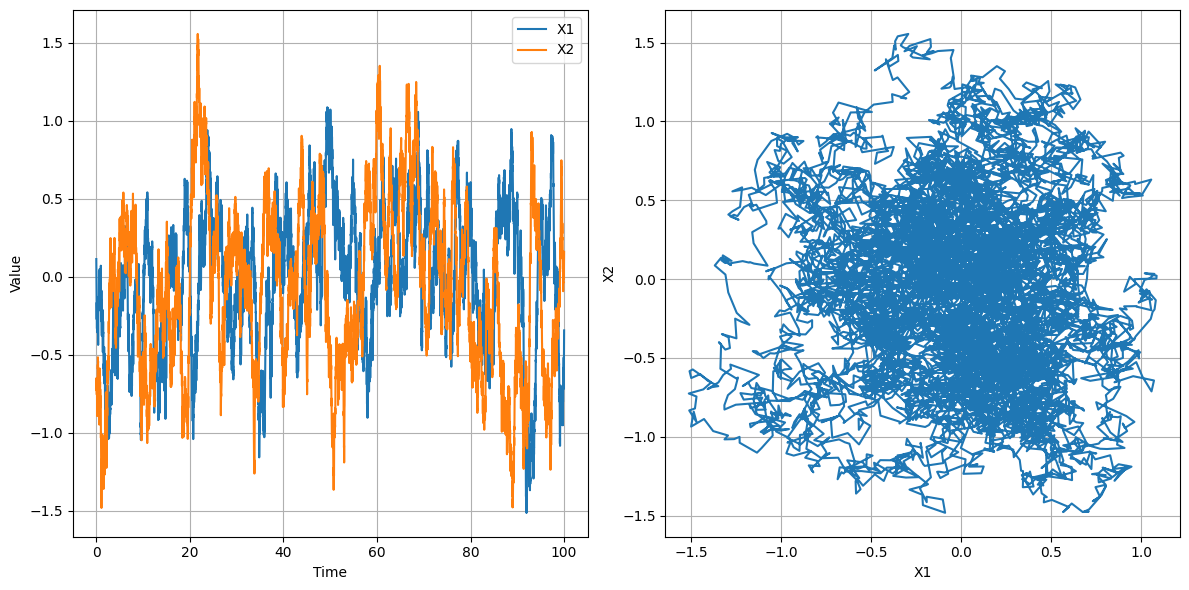

10000 samples


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
dim = 2    # Dimension of the process
drift_matrix = np.array([
    [-0.7, 0.3],
    [-0.5, -0.4]
])
diffusion_matrix = 0.5*np.eye(dim)
X0 = np.array([1., -1.])

# Simulation parameters
burnin_time = 20.0
training_time = 100.0
dt = 0.01  # Time step
n_train = int(training_time/dt)  # Number of training samples

# Simulate the process
X, t = simulate_ou_process(T=burnin_time+training_time, dt=dt, X0=X0, drift_matrix=drift_matrix, sigma=diffusion_matrix, dim=dim)

train_traj = X[-n_train:]
#train_traj += 0.01*np.random.randn(*train_traj.shape)


# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t[:n_train], train_traj[:, 0], label='X1')
plt.plot(t[:n_train], train_traj[:, 1], label='X2')
#plt.title('Ornstein-Uhlenbeck Process with Non-symmetric Drift')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_traj[:, 0], train_traj[:, 1])
#plt.title('Phase Portrait')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)

plt.tight_layout()
plt.show()
print(f'{n_train} samples')


In [4]:
from scipy.spatial.distance import pdist

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
#data_pdist = pdist(train_traj)
#lscale = np.quantile(data_pdist, 0.5)
lscale = 0.75

# Dual

In [ ]:
from sklearn.gaussian_process.kernels import RBF
kernel = RBF(length_scale=lscale)
K = kernel(train_traj)

In [ ]:
evd_to = dual_ToRRR(K=K, dt = dt, tikhonov_reg=1e-6,rank=7)

In [ ]:
evd = dual_LaRRR(K=K, dt = dt, context_length= n_train//2, shift = 30, tikhonov_reg=1e-5,rank=7)

In [ ]:
np.linalg.eigvals(drift_matrix),evd['values'][-3:-1],evd_to['values'][-3:-1]

(array([-0.55+0.35707142j, -0.55-0.35707142j]),
 array([-0.53677317-0.15663305j, -0.53677317+0.15663305j]),
 array([-0.83123264-0.24554767j, -0.83123264+0.24554767j]))

# Primal RFF

In [568]:
num_random_features = 500

orf = OrthogonalRandomFeatures(input_dim=2, num_random_features = num_random_features,
        length_scale = lscale, rng_seed = None)

def feature_map(X):
    features_pt = orf(torch.from_numpy(X))
    return features_pt.numpy(force=True)

In [477]:
true_evals = np.linalg.eigvals(drift_matrix)

In [478]:
evd_to = primal_ToRRR(Z=feature_map(train_traj), dt = dt, tikhonov_reg=1e-7,rank=5)

In [489]:
evd = primal_LaRRR(Z=feature_map(train_traj), dt = dt, context_length= n_train, shift = 0.5, tikhonov_reg=1e-7, rank=5)

In [490]:
true_evals,evd['values'][-2:],evd_to['values'][-2:]

(array([-0.55+0.35707142j, -0.55-0.35707142j]),
 array([-6.62790261e-01+0.34929122j,  2.34604934e-04+0.j        ]),
 array([-0.68249829+0.4600407j, -0.03374859+0.j       ]))

In [565]:
# Set random seed for reproducibility
np.random.seed(42)

num_random_features = 500
lscale = 0.5

orf = OrthogonalRandomFeatures(input_dim=2, num_random_features = num_random_features,
        length_scale = lscale, rng_seed = None)

def feature_map(X):
    features_pt = orf(torch.from_numpy(X))
    return features_pt.numpy(force=True)

trials = 10
time_steps = [0.01,0.001]
dt0 = time_steps[-1]

burnin_time = 20.0
training_time = 100.0

#hp = {'shift':[0.1, 0.2, 0.3, 0.5, 0.8],'reg': [1e-9, 1e-8, 1e-7, 1e-6]} 
hp = {'lscale': [0.25, 0.5, 0.75], 'shift':[0.1, 0.2, 0.3, 0.5, 0.75, 0.95],'reg': [1e-5, 5e-6, 1e-6, 5e-7, 1e-7, 5e-8]} 

true_evals = np.linalg.eigvals(drift_matrix)

predictions = np.zeros((trials, len(time_steps),2,2),dtype=np.complex64)
errors = np.zeros((trials, len(time_steps), 2))
for t_ in range(trials):
    X, _ = simulate_ou_process(T=burnin_time+training_time, dt=dt0, X0=X0, drift_matrix=drift_matrix, sigma=diffusion_matrix, dim=dim)
    for dt_, dt in enumerate(time_steps):
        train_traj = X[-int(training_time/dt0)::int(dt/dt0)]
        lambda0_to = np.inf
        lambda0_ig = np.inf
        print(f"Trial {t_+1}/{trials}, dt: {dt}")
        for lscale in hp['lscale']:
            orf = OrthogonalRandomFeatures(input_dim=2, num_random_features = num_random_features,
                    length_scale = lscale, rng_seed = 42)
            def feature_map(X):
                features_pt = orf(torch.from_numpy(X))
                return features_pt.numpy(force=True)
            for reg_, reg in enumerate(hp['reg']):
                evd_to = primal_ToRRR(Z=feature_map(train_traj), dt = dt, tikhonov_reg=reg,rank=5)
                lambda0_to_new = np.abs(evd_ig['values'][-1]) + np.std(evd_ig['right'][:,-1])
                if lambda0_to_new < lambda0_to:
                    lambda0_to = lambda0_to_new
                    predictions[t_,dt_,1,:] = evd_to['values'][-3:-1]
                    reg_best_to = reg
                    lscale_best_to = lscale
                for shift_, shift in enumerate(hp['shift']):
                    evd_ig = primal_LaRRR(Z=feature_map(train_traj), dt = dt, context_length= train_traj.shape[0], shift = shift, tikhonov_reg=reg, rank=5)
                    #print(f'IG (reg={reg}, shift={shift}) evals {ig_evals}')
                    lambda0_ig_new = np.abs(evd_ig['values'][-1]) + np.std(evd_ig['right'][:,-1])
                    if lambda0_ig_new < lambda0_ig:
                        lambda0_ig = lambda0_ig_new
                        predictions[t_,dt_,0,:] = evd_ig['values'][-3:-1]
                        reg_best = reg
                        shift_best = shift
                        lscale_best = lscale
        print(f'Choosen TO (lscale ={lscale_best_to},reg={reg_best_to}) evals {predictions[t_,dt_,1,:]},{lambda0_to}')
        print(f'Choosen IG (lscale ={lscale_best}, reg={reg_best}, shift={shift_best}) evals {predictions[t_,dt_,0,:]}, {lambda0_ig}')
        errors[t_,dt_,0] = np.abs(true_evals[0]-predictions[t_,dt_,0,-1])/np.abs(true_evals[0])        
        errors[t_,dt_,1] = np.abs(true_evals[0]-predictions[t_,dt_,1,-1])/np.abs(true_evals[0])
       

KeyboardInterrupt: 

In [ ]:
#np.save('OU_predictions_10.npy', predictions)
#np.save('OU_errors_10.npy', errors)

In [14]:
predictions = np.load('OU_predictions_10.npy')
errors= np.load('OU_errors_10.npy')
time_steps = [0.01,0.001]
true_evals = np.linalg.eigvals(drift_matrix)

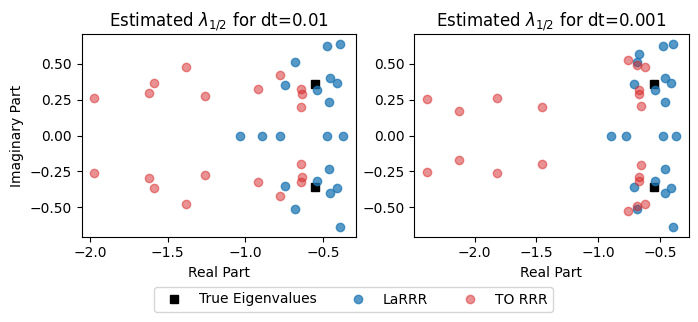

In [23]:
plt.figure(figsize=(3 * len(time_steps) + 1, 3))
for dt_, dt in enumerate(time_steps):
    plt.subplot(1, len(time_steps), dt_ + 1)
    plt.plot(np.real(true_evals), np.imag(true_evals), 'ks', label='True Eigenvalues')
    plt.plot(np.real(predictions[:, dt_, 0]), np.imag(predictions[:, dt_, 0]), 'o ', color = 'tab:blue', label='LaRRR', alpha=0.75)
    plt.plot(np.real(predictions[:, dt_, 1]), np.imag(predictions[:, dt_, 1]), 'o ', color = 'tab:red', label='TO RRR', alpha=0.5)
    plt.xlabel('Real Part')
    if dt_==0:
        plt.ylabel('Imaginary Part')
    plt.title('Estimated $\\lambda_{1/2}$' + f' for dt={dt}')

# Add a single legend for the entire figure
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles[::2], labels[::2], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
plt.tight_layout()
plt.show()